# Grab the vertices of the glacier terminus boxes in pixel coordinates

### Jukes Liu

The vertices of the glacier terminus box will be used to calculate a midpoint of the left edge of the terminus box, which will be our reference point for calculating terminus position.

### Import packages, set basepath, grab BoxIDs for terminus boxes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import midpoint

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [7]:
# #grab the BoxIDs
downloaded_df = pd.read_csv(basepath+'Images_downloaded_SE.csv', sep=',', usecols =[1, 2, 3], dtype=str)
downloaded_df = downloaded_df.set_index('BoxID')
# # pathrows_df = pathrows_df.drop('215')
# pathrows_df
BoxIDs = set(list(downloaded_df.index))
print(BoxIDs)
# BoxIDs = ['001', '002', '004', '033', '120', '174', '235', '259', '277', '531', '147', '148', '150', '152', '190', '191', '192', '193', '194', '195', '195','213', '214']

{'219', '150', '155', '175', '280', '225', '279', '205', '140', '185', '100', '277', '135', '265', '260', '174', '148', '240', '191', '194', '235', '270', '110', '200', '147', '285', '210', '192', '245', '190', '180', '120', '195', '115', '290', '152', '193', '214', '255', '130', '220', '213', '160'}


### Read in terminus box rasters and perform a visual check

In [8]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/R_Box"+BoxID+"_raster_cut.pgm"
    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes.update( {BoxID: termbox} )

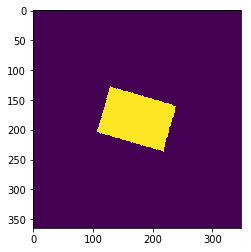

In [10]:
#visualize each terminus box rasters by BoxID
termplot = plt.imshow(termboxes['245'])
plt.show()

### Find x,y coordinates of box vertices and midpoints of left and right edges to get the centerline

    1) Left side
        1A) Top Left (lowest x*y)
        1B) Bottom Left (highest y/x)
        1C) Midpoint of 1A and 1B:
$\dfrac{x_{1}+x_{2}}{2}$ , $\dfrac{y_{1}+y_{2}}{2}$

    2) Right side
        2A) Top Right (highest y/x)
        2B) Bottom Right (highest x*y)
        2C) Midpoint of 2A and 2B.
        
    3) Centerline equation

Calculate the equation for the centerline (slope between the two midpoints). Just need to calculate slope: $m =\dfrac{y_{2}-y_{1}}{x_{2}-x_{1}}$

and solve for the intercept using one of the midpoint coordinate pairs: $b = y - mx$

$y = mx + b$

In [11]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}; boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}

#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []
midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []
mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []
mids_r075_x = []; mids_r075_y = []

#create lists to store the slopes and intercepts of the centerline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

#for all the box rasters
for BoxID in BoxIDs:
    BOI = termboxes[BoxID] #Read in the raster of the BoxID of interest
    yindices, xindices = np.where(BOI > 0) #keep the pixels of where thevalue is nonzero (where the box exists)
    boxes_ycoords.update( {BoxID: yindices}); boxes_xcoords.update( {BoxID: xindices}) #add box coordinates to the dictionary
    
    #1A) FIND THE TOP LEFT COORDINATES (min x and min y)
    xy = xindices*yindices
    min_xy_i = np.where(xy == np.min(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy
    if BoxID == '001':
        topleft = [6, 26]
    else:
         topleft = [xindices[min_xy_i], yindices[min_xy_i]]
    topleft_coords.update(  {BoxID: topleft}  )     #Add to dictionary of topleft coordinates
    print("Top left", topleft)
    
    
    #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
    max_xy = np.max(xy)
    max_xy_i = np.where(xy == max_xy)[0][0]
    bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
    bottomright_coords.update( {BoxID: bottomright})
    print("Bottom right", bottomright)
    
    #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
    y_x = yindices/xindices
    max_y_x = np.max(y_x) #Find the highest y/x value
    #Find the x and y pair corresponding to that y/x using the index
    max_y_x_i = np.where(y_x == max_y_x)[0][0]
    bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
    print("Bottom left", bottomleft)
    bottomleft_coords.update( {BoxID: bottomleft}  ) #Add to dictionary of bottomleft coordinates
    
    #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
    x_y = xindices/yindices
    max_x_y = np.max(x_y)  # find highest x/y value
    max_x_y_i = np.where(x_y == max_x_y)[0][0]  #Find the x, y pair correpsonding to the maximum x/y using the index
    topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    topright_coords.update( {BoxID: topright} )
    print("Top right", topright)
    
    #1C and 2C) CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    #Left
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    #Right
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    
#     #Add x and y coordinates to dictionaries
#     midpoints_x.update( {BoxID: midpoint_x}  )
#     midpoints_y.update( {BoxID: midpoint_y}  )
#     midpoints_r_x.update( {BoxID: midpoint_r_x})
#     midpoints_r_y.update( {BoxID: midpoint_r_y})
    
    #GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y)
    
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    #3) CALCULATE CENTERLINE EQUATIONS
    #1/2
    #slope = (y2-y1)/(x2-x1)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x)
    #y-intercept = y1 - m*x1
    b = midpoint_y - (m*midpoint_x)
#     print("y =", m, "x +", b)

    #1/4
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    
    #3/4
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    #append BoxIDs, slopes, intercepts, midpoints, and centerlines to lists
    boxes.append(BoxID); midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)
    
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    
    slope_50.append(m); intercept_50.append(b)
    slope_25.append(m025) ;intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
#create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.drop_duplicates().set_index('BoxID')
total_df

Top left [117, 108]
Bottom right [192, 213]
Bottom left [95, 184]
Top right [213, 137]
Top left [0, 12]
Bottom right [39, 46]
Bottom left [0, 12]
Top right [38, 19]
Top left [81, 71]
Bottom right [134, 150]
Bottom left [66, 132]
Top right [149, 88]
Top left [50, 64]
Bottom right [101, 94]
Bottom left [49, 90]
Top right [101, 66]
Top left [163, 131]
Bottom right [248, 276]
Bottom left [130, 241]
Top right [280, 167]
Top left [144, 157]
Bottom right [267, 263]
Bottom left [136, 252]
Top right [275, 168]
Top left [255, 228]
Bottom right [401, 432]
Bottom left [260, 435]
Top right [396, 224]
Top left [127, 153]
Bottom right [260, 198]
Bottom left [131, 206]
Top right [256, 144]
Top left [76, 100]
Bottom right [157, 163]
Bottom left [69, 151]
Top right [164, 112]
Top left [234, 117]
Bottom right [281, 307]
Bottom left [203, 293]
Top right [312, 131]
Top left [158, 161]
Bottom right [291, 268]
Bottom left [143, 235]
Top right [307, 193]
Top left [93, 116]
Bottom right [182, 176]
Bottom left 

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
219,106.0,146.0,202.5,175.0,0.300518,114.145078,111.50,127.00,207.75,156.00,0.301299,93.492228,100.50,165.00,197.25,194.00,0.299742,134.797927
150,0.0,12.0,38.5,32.5,0.532468,12.000000,0.00,12.00,38.25,25.75,0.359477,12.000000,0.00,12.00,38.75,39.25,0.703226,12.000000
155,73.5,101.5,141.5,119.0,0.257353,82.584559,77.25,86.25,145.25,103.50,0.253676,66.369485,69.75,116.75,137.75,134.50,0.261029,98.799632
175,49.5,77.0,101.0,80.0,0.058252,74.116505,49.75,70.50,101.00,73.00,0.048780,67.601942,49.25,83.50,101.00,87.00,0.067633,80.631068
280,146.5,186.0,264.0,221.5,0.302128,141.738298,154.75,158.50,272.00,194.25,0.304904,111.745745,138.25,213.50,256.00,248.75,0.299363,171.730851
225,140.0,204.5,271.0,215.5,0.083969,192.744275,142.00,180.75,273.00,191.75,0.083969,168.826336,138.00,228.25,269.00,239.25,0.083969,216.662214
279,257.5,331.5,398.5,328.0,-0.024823,337.891844,256.25,279.75,397.25,276.00,-0.026596,286.110816,258.75,383.25,399.75,380.00,-0.023050,389.672872
205,129.0,179.5,258.0,171.0,-0.065891,188.000000,128.00,166.25,257.00,157.50,-0.067829,174.684109,130.00,192.75,259.00,184.50,-0.063953,201.315891
140,72.5,125.5,160.5,137.5,0.136364,115.613636,74.25,112.75,162.25,124.75,0.136364,102.625000,70.75,138.25,158.75,150.25,0.136364,128.602273


### Visual check of the vertices, midpoints, and centerlines by plotting over terminus box:

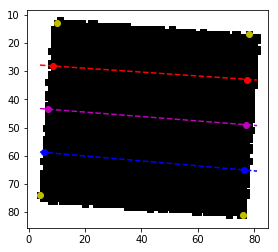

In [12]:
#Choose which glacier BoxID to check:
BOI_ID = '120'

#plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')

#plot the vertices
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='y')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='y')
plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='y')
plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='y')

#plot midpoints
plt.scatter(total_df.at[BOI_ID,'lmid50_x'], total_df.at[BOI_ID,'lmid50_y'], c='m')
plt.scatter(total_df.at[BOI_ID, 'rmid50_x'], total_df.at[BOI_ID, 'rmid50_y'], c='m')
plt.scatter(total_df.at[BOI_ID,'lmid25_x'], total_df.at[BOI_ID,'lmid25_y'], c='r')
plt.scatter(total_df.at[BOI_ID, 'rmid25_x'], total_df.at[BOI_ID, 'rmid25_y'], c='r')
plt.scatter(total_df.at[BOI_ID,'lmid75_x'], total_df.at[BOI_ID,'lmid75_y'], c='b')
plt.scatter(total_df.at[BOI_ID, 'rmid75_x'], total_df.at[BOI_ID, 'rmid75_y'], c='b')

#plot the centerlines in cyan
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID]))
y50=(total_df.at[BOI_ID, 'm50'])*x + (total_df.at[BOI_ID, 'b50'])
y25=(total_df.at[BOI_ID, 'm25'])*x + (total_df.at[BOI_ID, 'b25'])
y75=(total_df.at[BOI_ID, 'm75'])*x + (total_df.at[BOI_ID, 'b75'])
plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
         
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.show()

### Drop right midpoint columns and dataframe to csv

In [13]:
#drop the right midpoints
# total_df = total_df.drop(['rmid50_x', 'rmid50_y', 'rmid25_x', 'rmid25_y', 'rmid75_x', 'rmid75_y'], axis=1)
total_df = total_df.drop(['rmid50_y', 'rmid25_y', 'rmid75_y'], axis=1)
total_df

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
219,106.0,146.0,202.5,0.300518,114.145078,111.50,127.00,207.75,0.301299,93.492228,100.50,165.00,197.25,0.299742,134.797927
150,0.0,12.0,38.5,0.532468,12.000000,0.00,12.00,38.25,0.359477,12.000000,0.00,12.00,38.75,0.703226,12.000000
155,73.5,101.5,141.5,0.257353,82.584559,77.25,86.25,145.25,0.253676,66.369485,69.75,116.75,137.75,0.261029,98.799632
175,49.5,77.0,101.0,0.058252,74.116505,49.75,70.50,101.00,0.048780,67.601942,49.25,83.50,101.00,0.067633,80.631068
280,146.5,186.0,264.0,0.302128,141.738298,154.75,158.50,272.00,0.304904,111.745745,138.25,213.50,256.00,0.299363,171.730851
225,140.0,204.5,271.0,0.083969,192.744275,142.00,180.75,273.00,0.083969,168.826336,138.00,228.25,269.00,0.083969,216.662214
279,257.5,331.5,398.5,-0.024823,337.891844,256.25,279.75,397.25,-0.026596,286.110816,258.75,383.25,399.75,-0.023050,389.672872
205,129.0,179.5,258.0,-0.065891,188.000000,128.00,166.25,257.00,-0.067829,174.684109,130.00,192.75,259.00,-0.063953,201.315891
140,72.5,125.5,160.5,0.136364,115.613636,74.25,112.75,162.25,0.136364,102.625000,70.75,138.25,158.75,0.136364,128.602273


#### Export to Boxes_coords_pathrows.csv

In [14]:
total_df.to_csv(path_or_buf = basepath+'Boxes_coords_pathrows_SE.csv', sep=',')